In [126]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objs as go
import plotly
plotly.__version__

'3.10.0'

In [127]:
sns.set(style='darkgrid')
mpl.rcParams['figure.figsize'] = (16,19)

In [130]:
dataPath_Raw = ("data/PROF_small_flat_table.csv")
#dataPath_Processed = ("../data/processed/")

pd.set_option("display.max_rows", 500)

In [129]:
df_analyse = pd.read_csv(dataPath_Raw, sep=";")
df_analyse.sort_values('date', ascending = True).head()

FileNotFoundError: [Errno 2] File b'data/PROF_small_flat_table.csv.csv' does not exist: b'data/PROF_small_flat_table.csv.csv'

In [101]:
df_analyse.Germany[35]

27

In [102]:
N0 = 2000000
beta = 0.4
gamma = 0.1

# S + I + R = N

I0 = 36
S0 = N0 - I0
R0 = 0

print(S0)

1999964


In [103]:
def SIR_model(SIR, beta, gamma):
    
    S,I,R = SIR
    dS = -beta * S * I/N0
    dI = beta * S * I/N0 - gamma * I
    dR = gamma * I
    
    return([dS, dI, dR])
    

In [104]:
SIR = np.array([S0,I0,R0])

propagation_rates = pd.DataFrame(columns={'Susceptible':S0,
                                          'Infected':I0,
                                          'Recovered':R0                                                  
                                         })
                                 
for each in np.arange(100):
    new_delta_vector = SIR_model(SIR, beta, gamma)
    SIR = SIR + new_delta_vector
    
    propagation_rates = propagation_rates.append({'Susceptible':SIR[0],
                                                  'Infected':SIR[1],
                                                  'Recovered':SIR[2],                         
                                                },ignore_index=True
                                                )
                                 



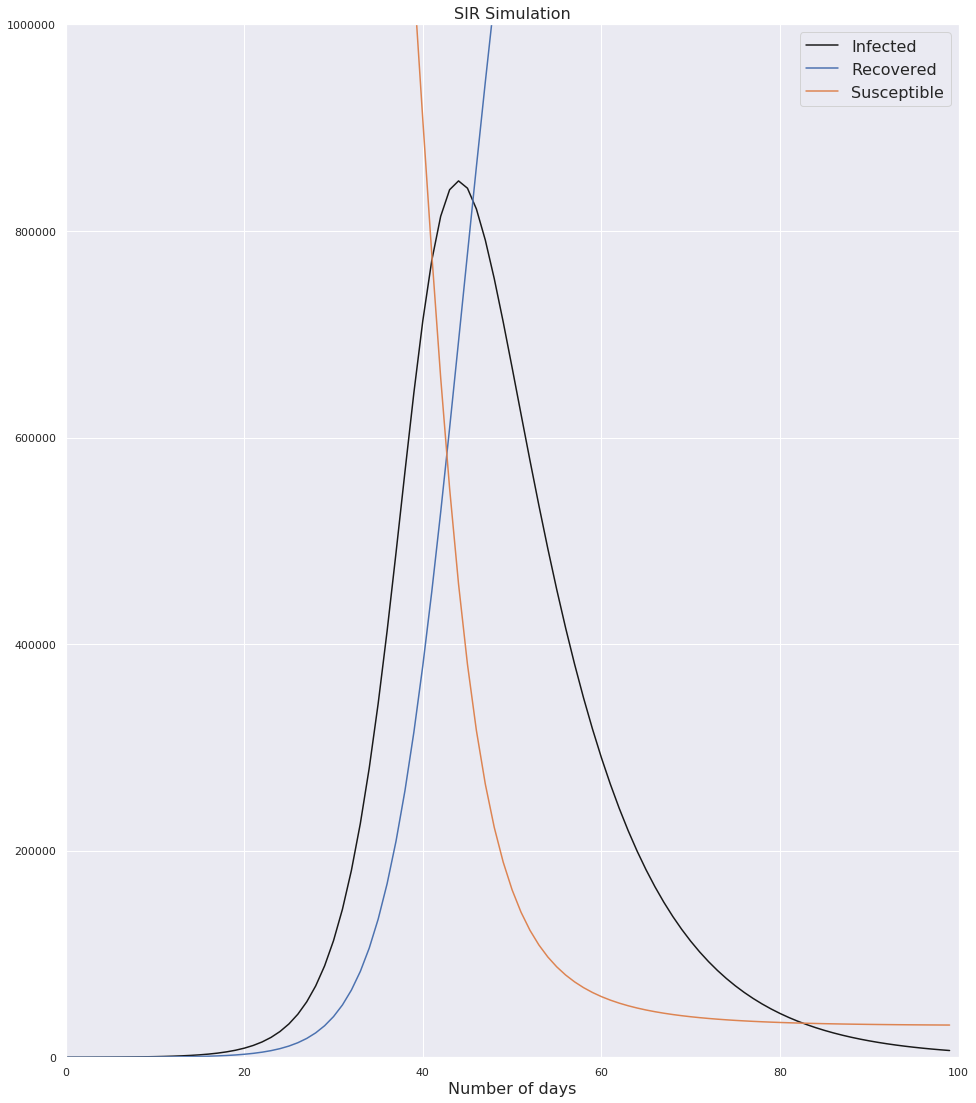

In [105]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.Infected, label = 'Infected', color= 'k')
ax1.plot(propagation_rates.index, propagation_rates.Recovered, label = 'Recovered')
ax1.plot(propagation_rates.index, propagation_rates.Susceptible, label = 'Susceptible')

ax1.set_ylim(10,1000000)
ax1.set_xlim(0,100)
ax1.set_yscale('linear')
ax1.set_title('SIR Simulation', size= 16)
ax1.set_xlabel('Number of days', size=16)
ax1.legend(loc='best',
          prop={'size':16})

## Fitting the parameters

In [106]:
from scipy import optimize
from scipy import integrate

In [107]:
ydata = np.array(df_analyse.Germany[35:])   #90
time = np.arange(len(ydata))

In [108]:
I0 = ydata[0]
S0 = 1000000
R0 = 0
beta

0.4

In [109]:
print(I0)

27


In [110]:
def SIR_model_fit(SIR, time, beta, gamma):
    
    S,I,R = SIR
    dS = -beta * S * I/N0
    dI = beta * S * I/N0 - gamma * I
    dR = gamma * I
    
    return([dS, dI, dR])
    

In [111]:
def fit_odeint(x,beta,gamma):
    return integrate.odeint(SIR_model_fit, (S0,I0,R0), time, args=(beta, gamma))[:,1]

# [,:1] infected rate

In [112]:
# Integrate

popt = [0.4, 0.1]  #beta, gamma

fit_odeint(time, *popt)

array([2.70000000e+01, 2.98395981e+01, 3.29777983e+01, 3.64459916e+01,
       4.02788674e+01, 4.45147594e+01, 4.91960276e+01, 5.43694809e+01,
       6.00868439e+01, 6.64052711e+01, 7.33879168e+01, 8.11045632e+01,
       8.96323143e+01, 9.90563617e+01, 1.09470830e+02, 1.20979713e+02,
       1.33697900e+02, 1.47752315e+02, 1.63283175e+02, 1.80445369e+02,
       1.99409989e+02, 2.20366012e+02, 2.43522159e+02, 2.69108940e+02,
       2.97380912e+02, 3.28619163e+02, 3.63134048e+02, 4.01268204e+02,
       4.43399862e+02, 4.89946497e+02, 5.41368833e+02, 5.98175250e+02,
       6.60926616e+02, 7.30241596e+02, 8.06802462e+02, 8.91361469e+02,
       9.84747822e+02, 1.08787529e+03, 1.20175053e+03, 1.32748214e+03,
       1.46629054e+03, 1.61951867e+03, 1.78864362e+03, 1.97528921e+03,
       2.18123951e+03, 2.40845347e+03, 2.65908056e+03, 2.93547740e+03,
       3.24022563e+03, 3.57615055e+03, 3.94634095e+03, 4.35416966e+03,
       4.80331480e+03, 5.29778158e+03, 5.84192427e+03, 6.44046796e+03,
      

In [113]:
popt, pcov = optimize.curve_fit(fit_odeint, time, ydata)
perr = np.sqrt(np.diag(pcov))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

overflow encountered in double_scalars

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

overflow encountered in double_scalars



In [114]:
print('Standard deviation errors : ', str(perr), 'Infection Start : ', ydata[0])


Standard deviation errors :  [0.00897179 0.0041884 ] Infection Start :  27


In [115]:
fitted = fit_odeint(time, *popt)

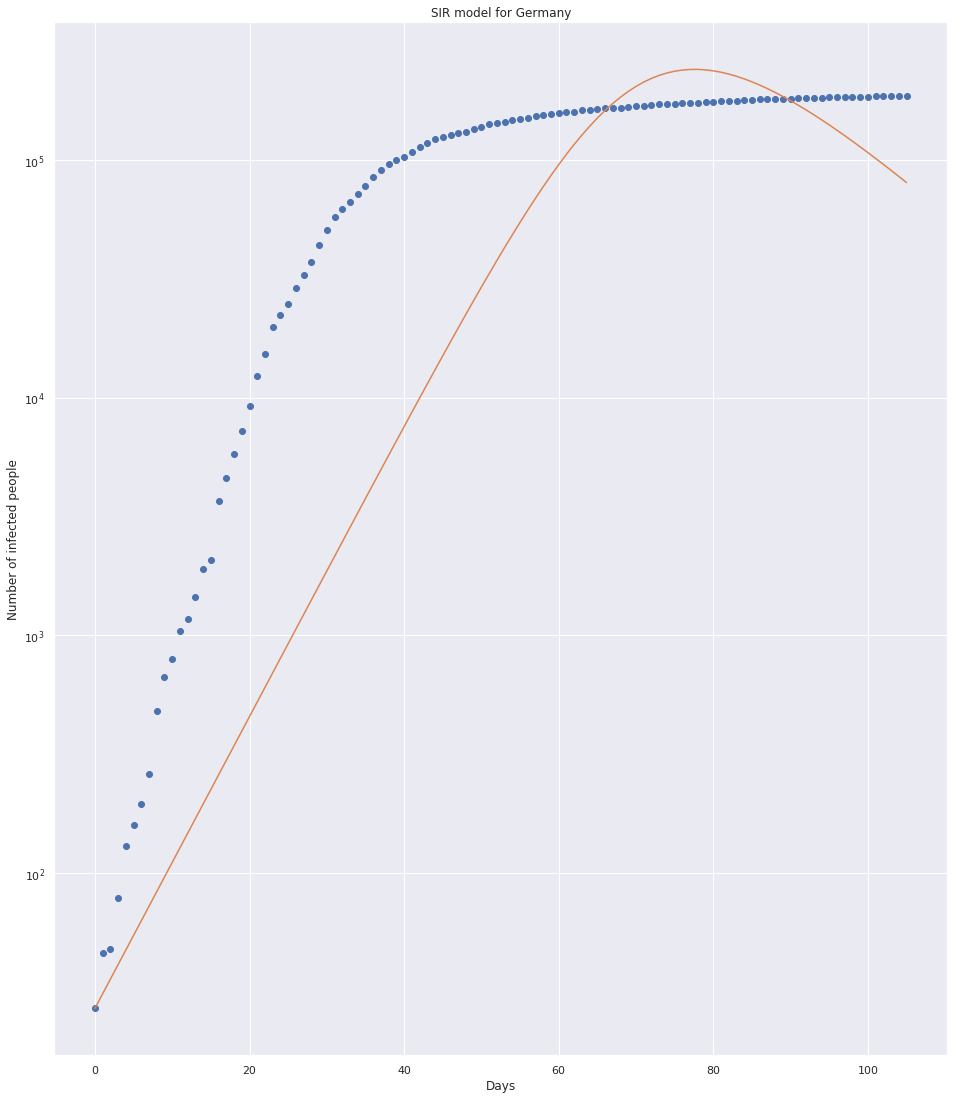

Optimal Parameters : beta =  0.46533922294076707 gamma =  0.09128555167984506
Reproduction number, R0 :  5.0976218511862195


In [116]:
plt.semilogy(time, ydata, 'o')
plt.semilogy(time, fitted)
plt.title('SIR model for Germany')
plt.ylabel('Number of infected people')
plt.xlabel('Days')
plt.show()

print('Optimal Parameters : beta = ', popt[0], 'gamma = ', popt[1])
print('Reproduction number, R0 : ', popt[0]/popt[1])

## Dynamic Beta 

In [117]:
t_initial = 21
t_intro_measures = 14
t_hold = 21
t_relax = 21

beta_max = 0.4
beta_min = 0.11
gamma = 0.1


pd_beta = np.concatenate((np.array(t_initial*[beta_max]),
                          np.linspace(beta_max, beta_min, t_intro_measures),
                          np.array(t_hold * [beta_min]),
                          np.linspace(beta_min, beta_max, t_relax)
                        ))

pd_beta

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.37769231, 0.35538462, 0.33307692,
       0.31076923, 0.28846154, 0.26615385, 0.24384615, 0.22153846,
       0.19923077, 0.17692308, 0.15461538, 0.13230769, 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.11      , 0.11      , 0.11      ,
       0.11      , 0.11      , 0.1245    , 0.139     , 0.1535    ,
       0.168     , 0.1825    , 0.197     , 0.2115    , 0.226     ,
       0.2405    , 0.255     , 0.2695    , 0.284     , 0.2985    ,
       0.313     , 0.3275    , 0.342     , 0.3565    , 0.371  

In [118]:
SIR = np.array([S0,I0,R0])

propagation_rates = pd.DataFrame(columns={'Susceptible':S0,
                                          'Infected':I0,
                                          'Recovered':R0                                                  
                                         })
                                 
for each_beta in pd_beta:
    new_delta_vector = SIR_model(SIR, each_beta, gamma)
    SIR = SIR + new_delta_vector
    
    propagation_rates = propagation_rates.append({'Susceptible':SIR[0],
                                                  'Infected':SIR[1],
                                                  'Recovered':SIR[2],                         
                                                },ignore_index=True
                                                )
                                 



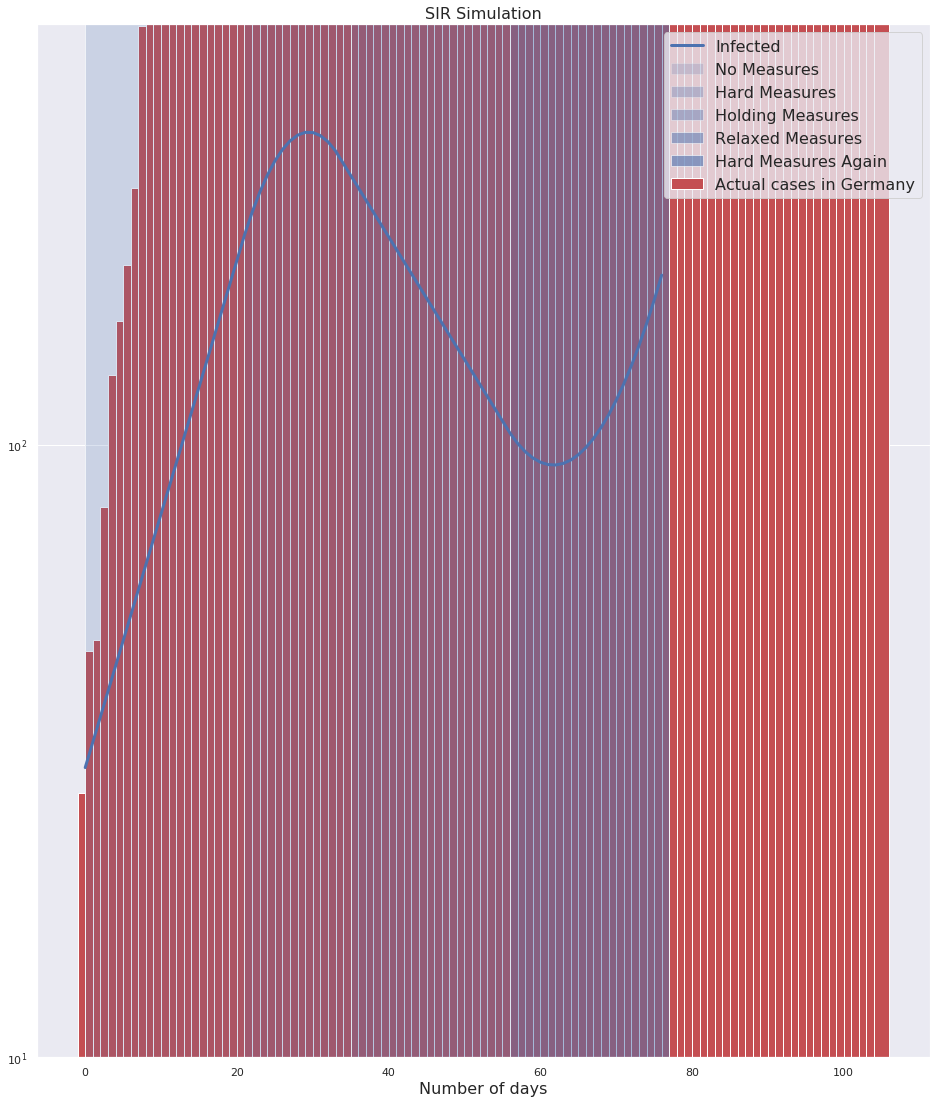

In [119]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index, propagation_rates.Infected, label = 'Infected', linewidth = 3)
#ax1.plot(propagation_rates.index, propagation_rates.Recovered, label = 'Recovered')
#ax1.plot(propagation_rates.index, propagation_rates.Susceptible, label = 'Susceptible')

ax1.bar(np.arange(len(ydata)), ydata, width=2, label = 'Actual cases in Germany', color = 'r')
t_phases = np.array([t_initial, t_intro_measures, t_hold, t_relax]).cumsum()

ax1.axvspan(0, t_phases[0], facecolor='b', alpha=0.2, label="No Measures")
ax1.axvspan(t_phases[0], t_phases[1], facecolor='b', alpha=0.3, label="Hard Measures")
ax1.axvspan(t_phases[1], t_phases[2], facecolor='b', alpha=0.4, label="Holding Measures")
ax1.axvspan(t_phases[2], t_phases[3], facecolor='b', alpha=0.5, label="Relaxed Measures")
ax1.axvspan(t_phases[3], len(propagation_rates.Infected),facecolor='b', alpha=0.6, label="Hard Measures Again")

ax1.set_ylim(10,1.5*max(propagation_rates.Infected))
#ax1.set_xlim(0,100)
ax1.set_yscale('log')
ax1.set_title('SIR Simulation', size= 16)
ax1.set_xlabel('Number of days', size=16)
ax1.legend(loc='best',
          prop={'size':16})